In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

In [312]:
import gpxpy
import gpxpy.gpx

gpx_file = open('Morning_Ride.gpx', 'r')
save_file = 'ride1.csv'
gpx = gpxpy.parse(gpx_file)
points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            time = str(point.time).split(' ')[1]
            time = str(time).split('+')[0]
            triple = f'{point.latitude},{point.longitude},{time}\n'
            points.append(triple)

with open(save_file, "w") as f:
    f.write('longitude,latitude,time\n')
    for p in points:
        f.write(p)

df = pd.read_csv(save_file)
prev_x = None
vel = (0,0)
noise_x = .0005
noise_v = 0.0005
for index, row in df.iterrows():
    if prev_x != None:
        vel = (row['longitude'] - prev_x[0], row['latitude'] - prev_x[1])
#             delta = datetime.date.fromisoformat(row['time']) - datetime.date.fromisoformat(prev_x[2])
#             vel[0] /= delta 

    df.at[index,'longitude'] = row['longitude'] + np.random.normal(0, noise_x)
    df.at[index,'latitude'] = row['latitude'] + np.random.normal(0, noise_x)
    df.at[index-1,'vel_x'] = vel[0] + np.random.normal(0, noise_v)
    df.at[index-1,'vel_y'] = vel[1] + np.random.normal(0, noise_v)
    prev_x = (row['longitude'], row['latitude'], row['time'])
# df.to_csv(f'rv_{save_file}', sep=',', index=False)


In [310]:
df

,longitude,latitude,time,vel_x,vel_y
0,42.443360,-76.486630,13:57:06,-0.000014,0.000037
1,42.440788,-76.486933,13:57:07,-0.000067,0.000171
2,42.442652,-76.486932,13:57:11,-0.000082,0.000144
3,42.442180,-76.486193,13:57:15,-0.000036,0.000039
4,42.442397,-76.487690,13:57:16,-0.000122,0.000114
...,...,...,...,...,...
2410,42.441497,-76.488785,16:14:04,-0.000025,-0.000047
2411,42.443248,-76.487865,16:14:06,-0.000013,-0.000007
2412,42.441080,-76.487606,16:14:07,-0.000004,-0.000002
2413,42.444060,-76.488587,16:14:09,NaN,NaN


In [5]:
save_file = 'ride1.csv'
og_df = pd.read_csv(save_file)
new_df = pd.read_csv(f'rv_{save_file}')

Text(0.5, 1.0, 'Ground Truth')

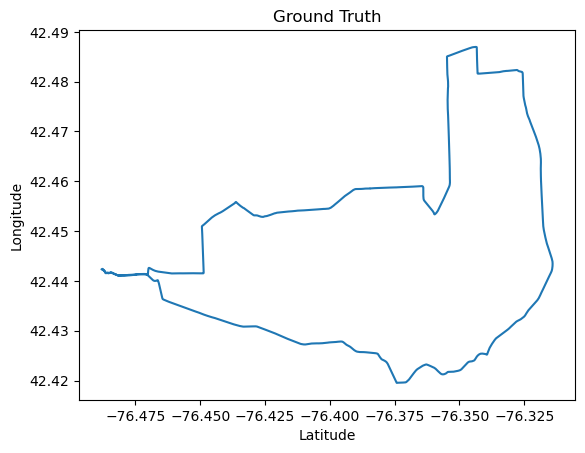

In [112]:
plt.plot(og_df['latitude'], og_df['longitude'])
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Ground Truth")

Text(0.5, 1.0, 'Noisy Data -- 0.0003 Noise Added')

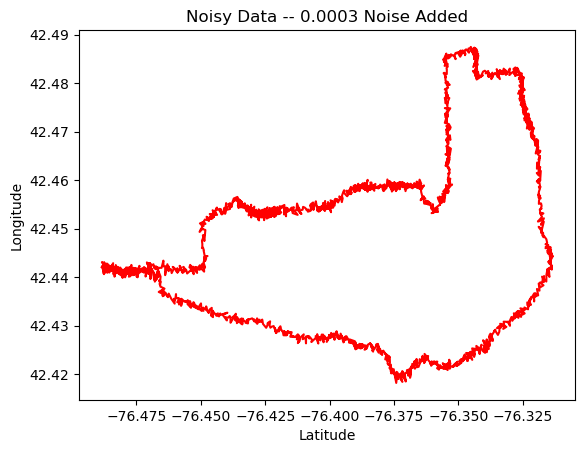

In [305]:
plt.plot(df['latitude'], df['longitude'], 'r')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Noisy Data -- 0.0003 Noise Added")


In [273]:
def kalman_filter(prev_x, prev_sigma, meas, A, D, vel, noise_state, noise_meas, combined):
    # inputs are np arrays
    if combined:
        prev_x = prev_x.reshape(-1,1)
        meas = meas.reshape(-1,1)
    mu_predict = A @ prev_x + vel
    sigma_predict = A @ prev_sigma @ A.T + noise_state
    K = sigma_predict @ D.T @ np.linalg.inv(D @ sigma_predict @ D.T + noise_meas)
    mu = mu_predict + K @ (meas - D @ mu_predict)
    sigma = sigma_predict - K @ D @ sigma_predict
    return mu, sigma

In [102]:
def MSE(x1, y1, x2, y2):
    n = len(x1)
    mse = 0
    for i in range(n):
        mse += np.sqrt((x1[i] - x2[i])**2 + (y1[i] - y2[i])**2)
    mse /= n
    return mse

In [325]:
r = len(og_df['latitude'])
result = np.zeros((r, 2))
mu = np.array([df['latitude'][0], df['longitude'][0]])
sigma = np.array([[0.0001, 0],[0, 0.0001]])
result[0,:] = mu
A = np.eye(2)
D = np.eye(2)
noise_state = 0.0005 * np.eye(2) # VELOCITY noise
noise_meas = 0.0005 * np.eye(2)

for i in range(1,r):
    meas = np.array([df['latitude'][i], df['longitude'][i]])
    vel = np.array([df['vel_x'][i-1], df['vel_y'][i-1]])
    mu, sigma = kalman_filter(mu, sigma, meas, A, D, vel, noise_state, noise_meas, False)
    result[i,:] = mu

In [326]:
result

array([[-76.48704367,  42.44174456],
       [-76.48732028,  42.44189837],
       [-76.48763797,  42.44172296],
       ...,
       [-76.48780682,  42.44261859],
       [-76.48847265,  42.44253728],
       [-76.48814178,  42.44264499]])

Text(0.5, 1.0, 'Kalman Filter w/ 0.0003 GPS Noise, 0.00005 Velocity Noise')

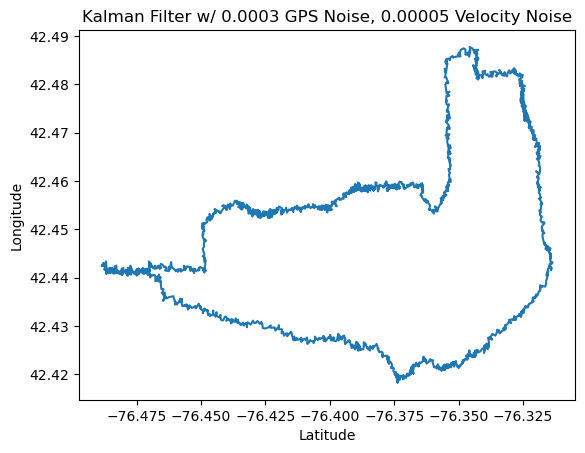

In [327]:
plt.plot(result[:,0], result[:,1])
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Kalman Filter w/ 0.0003 GPS Noise, 0.00005 Velocity Noise")
# plt.plot(og_df['latitude'], og_df['longitude'])
# plt.legend(['Kalman','Truth'])

In [315]:
mse_noisy = MSE(og_df['latitude'], og_df['longitude'], df['latitude'], df['longitude'])
print('MSE of Noisy Data: ', mse_noisy)
mse_kalman = MSE(og_df['latitude'], og_df['longitude'], result[:,0], result[:,1])
print('MSE after Kalman: ', mse_kalman)

MSE of Noisy Data:  0.0006238220929526625
MSE after Kalman:  0.0005216374323130022


In [12]:
from datetime import datetime

In [268]:
r = len(og_df['latitude'])
d1_temp = df.at[2413, 'time']
d2_temp = df.at[0, 'time']
d1 = datetime.strptime(d1_temp, "%H:%M:%S")
d2 = datetime.strptime(d2_temp, "%H:%M:%S")
l = int((d1-d2).total_seconds())

# r = df.at[2413, 'time'] - df.at[0,'time']
result = np.zeros((l, 4))
mu = np.array([df['latitude'][0], df['longitude'][0], df['vel_x'][0], df['vel_y'][0]])
sigma = 0.0001 * np.eye(4)
result[0,:] = mu
A = np.eye(4)
A[0:2,2:4] = np.eye(2)
D = np.concatenate((np.eye(2), np.zeros((2,2))), axis = 1)
noise_state = 0.0001 * np.eye(4)
noise_state[0:2,0:2] = np.zeros((2,2))
noise_meas = 0.0005 * np.eye(2)

iters = 0
maxDiff = 0
for i in range(1,r):
    d1_temp = df.at[i, 'time']
    d2_temp = df.at[i-1, 'time']
    d1 = datetime.strptime(d1_temp, "%H:%M:%S")
    d2 = datetime.strptime(d2_temp, "%H:%M:%S")
    time_diff = int((d1-d2).total_seconds())
    maxDiff = max(maxDiff, time_diff)
    meas = np.array([df['latitude'][i-1], df['longitude'][i-1]])
    mu, sigma = kalman_filter(mu, sigma, meas, A, D, np.zeros((4,1)), noise_state, noise_meas, True, False)
    result[iters,:] = mu.flatten()
    iters += 1
    for j in range(1, time_diff): 
        mu, sigma = kalman_filter(mu, sigma, np.zeros((2,1)), A, np.zeros((2,4)), np.zeros((4,1)), noise_state, noise_meas, True, True)
        result[iters,:] = mu.flatten()
        iters += 1
print(maxDiff)

334


Text(0.5, 1.0, 'Kalman Filter w/ 0.0005 GPS Noise, No Velocity Data')

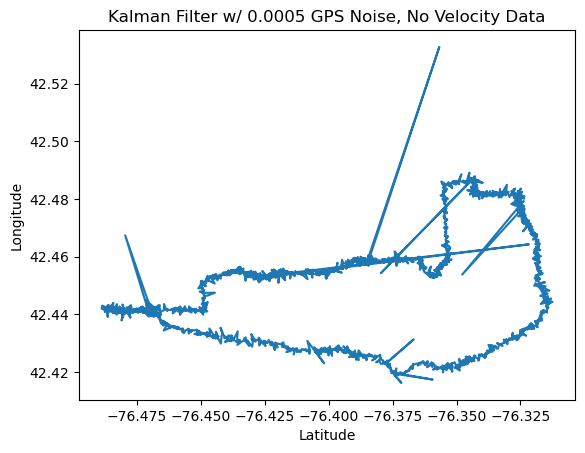

In [269]:
plt.plot(result[:,0], result[:,1])
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Kalman Filter w/ 0.0005 GPS Noise, No Velocity Data")

In [110]:
mse_noisy = MSE(og_df['latitude'], og_df['longitude'], df['latitude'], df['longitude'])
print('MSE of Noisy Data: ', mse_noisy)
mse_kalman = MSE(og_df['latitude'], og_df['longitude'], result[:,0], result[:,1])
print('MSE after Kalman: ', mse_kalman)

MSE of Noisy Data:  0.0006297531897056101
MSE after Kalman:  0.06395599816134823


In [43]:
from datetime import datetime 
d1_temp = df.at[2413, 'time']
d2_temp = df.at[0, 'time']
d1 = datetime.strptime(d1_temp, "%H:%M:%S")
d2 = datetime.strptime(d2_temp, "%H:%M:%S")

r = int((d1 - d2).total_seconds())
len(np.zeros(r))

8223

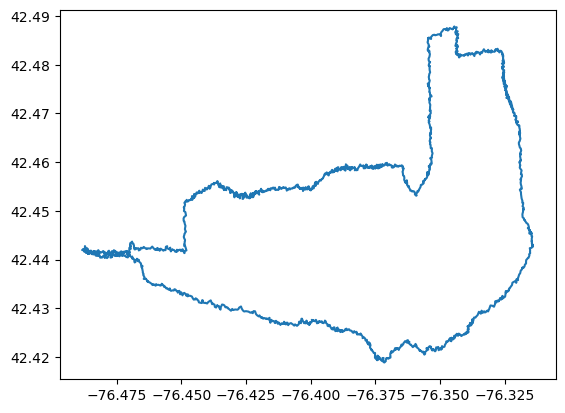

In [35]:
plt.plot(result[:,0], result[:,1])

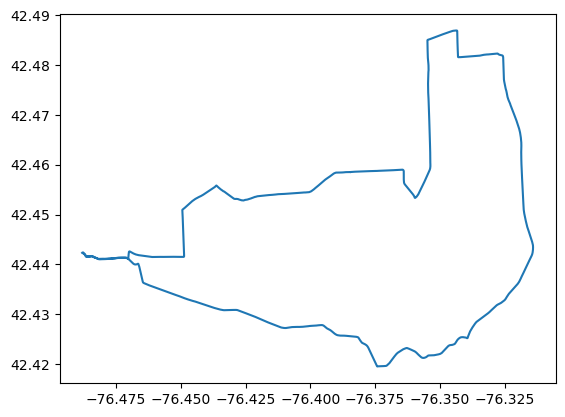

In [24]:
plt.plot(og_df['latitude'], og_df['longitude'])

In [ ]:
r = len(og_df['latitude'])
x_t = [(0,0,0,0) for i in range(r)]

for i in range(r):
    long, lat, time, v_x, v_y = df.at[index,'longitude'], df.at[index,'latitude'], df.at[index,'time'], df.at[index,'vel_x'], df.at[index,'vel_y']
    x_t[i][0] = x_t[i-1][0] + v_t[i-1][0]
    x_t[i][1] = x_t[i-1][1] + v_t[i-1][1]
    x_t[i][2] = v_x
    